<a href="https://colab.research.google.com/github/Batake/predict_index/blob/add_ipynb_ver/PredictIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使い方


*   細かい実行方法もあるけど，いったん実行は上の「ランタイム」の「全てのセルを実行」でできる
*   パラメータ変えたいときは下の方にある「変更するパラメータ」って書いてある下のとこのパラメータ変えれば良い
*   変えられるのは

1.   アップロードするファイル名
2.   使用する年月の開始時点と終了時点
3.   探索する係数範囲の最小値, 最大値
4.   探索の試行回数(これはそんな変える必要ない)





### この欄は細かい処理で理解する必要はない 変更できるパラメータの欄はもっと下にある

In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
import math
import copy
import os
from google.colab import files
import warnings
warnings.simplefilter('ignore')

day_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
day_sum = [0] + [sum(day_month[0:(i+1)]) for i in range(11)] #その月までの合計日数: 1月なら0日, 2月までなら0+31=31, 3月までなら0+31+28=59...

# データのロードと整理
def load_organize_csv(filename):
    # ローカルファイルをアップロードされていないならする
    if not os.path.isfile(filename):
        uploaded = files.upload()

    indice = pd.read_csv(filename, header=0, usecols=[0, 1]) #csvの1, 2列目読み込み
    indice["datetime"] = pd.to_datetime(indice['Date'])
    indice["Year"] = indice['datetime'].dt.year
    indice["Month"] = indice['datetime'].dt.month
    indice["Day"] = indice['datetime'].dt.day

    for i, d_m in enumerate(day_month):
        indice["Month"][indice["Month"]-1==i] = day_sum[i] #月をその月までの合計日数に変換
    indice['Date_Year'] = indice["Year"] + (indice["Month"] + indice["Day"])/365 # 年, 月, 日をそれまでの合算して年に変換
    x = indice["Date_Year"].values
    y = indice["Open"].values
    return x, y

# 探索される対象の関数 今回はあの本の　A+B*(tc -t)^m　を書いたつもり
def nonlinear_simple(x, a, b, c, d):
    return a + b*(abs(c-x)**d)

# 対象の関数の最適なパラメータを計算(係数は a, b, ...d の順に p_opt へ入る)
def calculate_target_parameters(x, y, n_try, start_year_, end_year_, bnds):
    # 開始年月日, 終了年月日以外のデータを除去
    x_copy = copy.deepcopy(x)
    x_copy[x_copy<start_year_] = 0
    x_copy[x_copy>end_year_] = 0
    y_copy = y[x_copy!=0]
    x_copy = x[x_copy!=0]
    # 最適パラメータを計算
    p_opt, _ = curve_fit(nonlinear_simple, x_copy, y_copy, maxfev=n_try, bounds=(
                (bnds["min_A"], bnds["min_B"], bnds["min_tc"], bnds["min_M"]), (bnds["max_A"], bnds["max_B"], bnds["max_tc"], bnds["max_M"])))
    print("A:", p_opt[0], ", B:", p_opt[1], ", tc:", p_opt[2], ", M:", p_opt[3])
    return p_opt

# 最適パラメータでのデータを計算
def calculate_y_by_p_opt(p_opt, start_year_, end_year_):
    # データを計算
    x_predicted = np.linspace(start_year_, end_year_+0.5, int((end_year_+0.5-start_year_)/0.1))
    y_predicted = [nonlinear_simple(x_p, p_opt[0], p_opt[1], p_opt[2], p_opt[3]) for x_p in x_predicted]

    return x_predicted, y_predicted

# 年月日を年表記に変換
def change_YMD_Year(Year, Month, Day):
    Month_ = day_sum[Month-1]
    Year_ = Year + (Month_ + Day)/365
    return Year_

# 年表記を年月日に変換 今は雑な計算
def change_Year_YMD(Year_):
    Year = int(Year_)
    Month = int((Year_ - Year)*12) + 1
    Day = int(((Year_ - Year)*12 - (Month - 1)) * 30)
    return Year, Month, Day

# 誤差の二乗の合計
def error_root_mean_squared(x, y, p_opt):
    y_predict = [nonlinear_simple(x_, p_opt[0], p_opt[1], p_opt[2], p_opt[3]) for x_ in x]
    error = np.mean([(y_ - y_m)**2 for y_, y_m in zip(y, y_predict)])
    print("実際の値との誤差: ", error)

# 暴落日の計算
def calculate_explosion(p_opt):
    fall_year = p_opt[2]
    year, month, day = change_Year_YMD(fall_year)
    print("暴落日: " + str(year)+"年"+str(month)+"月"+str(day)+"日")

# 実際のデータ, 予測したデータをプロット
def plot_raw_and_predicted(x, y, x_predicted, y_predicted):
    plt.plot(x, y)
    plt.plot(x_predicted, y_predicted)
    plt.legend(["Raw", "Predicted"])
    plt.xlabel("Year")
    plt.ylabel("Value")

# 本での係数
# p_opt_book = [327, -79, 87.65, 0.7]

# エラー算出
# print("自分の方法での誤差: ", error_root_mean_squared(x, y, p_opt))
# print("本での方法での誤差: ", error_root_mean_squared(x, y, p_opt_book))

def execute(filename, period_used, bnds, n_try):
    x, y = load_organize_csv(filename)
    
    start_year_ = change_YMD_Year(period_used["start_year"], period_used["start_month"], period_used["start_day"])
    end_year_ = change_YMD_Year(period_used["end_year"], period_used["end_month"], period_used["end_day"])

    p_opt = calculate_target_parameters(x, y, n_try, start_year_, end_year_, bnds)
    x_predicted, y_predicted = calculate_y_by_p_opt(p_opt, start_year_, end_year_)
    error_root_mean_squared(x, y, p_opt)
    calculate_explosion(p_opt)
    plot_raw_and_predicted(x, y, x_predicted, y_predicted)

### 変更するパラメータ

Saving indice_ori.csv to indice_ori.csv
A: 318.9644938623478 , B: -78.27118277317749 , tc: 1987.5999997337524 , M: 0.733185180343629
実際の値との誤差:  161.1783967091896
暴落日: 1987年8月5日


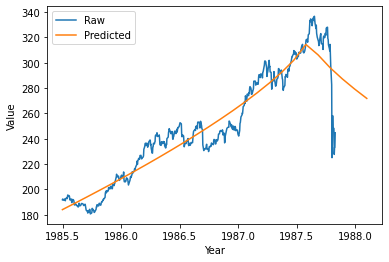

In [ ]:
# アップロードするファイル名
filename = "indice_ori.csv"
# 使用する年月の開始時点と終了時点
# 1985年7月1日: 1985.5年, 1987年8月7日: 1987.6年
period_used = {
    "start_year": 1985,
    "start_month": 7,
    "start_day": 1,
    "end_year": 1987,
    "end_month": 8,
    "end_day": 7,
}
# 探索する係数範囲の最小値, 最大値
bnds = {
    "min_A": -1000,
    "max_A": 1000,
    "min_B": -1000,
    "max_B": 1000,
    "min_tc": 1987.5,
    "max_tc": 1990.6,
    "min_M": 0,
    "max_M": 10,
}
# 探索の試行回数 とりあえず10000回でいいと思う
n_try = 10000

execute(filename, period_used, bnds, n_try)

